In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from models import Discriminator, Generator
import os
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Using cpu device


In [4]:
# CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(
    root="./data", train=True, transform=transform, download=True
)
train_loader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)

Files already downloaded and verified


In [5]:
def calculate_gradient_norm(model):
    total_norm = 0.0
    for param in model.parameters():
        if param.grad is not None:
            param_norm = param.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    return total_norm

In [6]:
def train_model(num_epochs=50, critic_iterations=1, latent_size=100, save_epochs=50, models_path = "./saved_models", progress_path = "./progress"):
    generator = Generator(latent_size).to(device)
    discriminator = Discriminator().to(device)

    criterion = nn.BCELoss()
    d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0004, betas=(0.5, 0.999), weight_decay=1e-5)
    g_optimizer = optim.Adam(generator.parameters(), lr=0.0004, betas=(0.5, 0.999), weight_decay=1e-5)
    
    if not os.path.exists(models_path):
        os.makedirs(models_path)
    if not os.path.exists(f"{models_path}/optimal"):
        os.makedirs(f"{models_path}/optimal")
    if not os.path.exists(f"{models_path}/epoch"):
        os.makedirs(f"{models_path}/epoch")
    if not os.path.exists(progress_path):
        os.makedirs(progress_path)
    if not os.path.exists(f"{progress_path}/static"):
        os.makedirs(f"{progress_path}/static")
    if not os.path.exists(f"{progress_path}/random"):
        os.makedirs(f"{progress_path}/random")
    
    training_metrics_df = pd.DataFrame()
        
    # Training loop
    lowest_loss = np.inf
    z_static = torch.randn(10, latent_size, device=device)
    for epoch in range(num_epochs):
        for _, (real_images, _) in enumerate(tqdm(train_loader,  desc=f'Epoch {epoch+1}/{num_epochs}')):
            real_images = real_images.to(device)
            batch_size = real_images.size(0)
            g_grad = []
            d_grad = []
            for _ in range(critic_iterations):
                # Train Discriminator: maximize log(D(x)) + log(1 - D(G(z)))
                # Implement One-sided label smoothing
                discriminator.zero_grad()
                real_labels = torch.ones(real_images.size(0), 1).to(device)
                fake_labels = torch.zeros(real_images.size(0), 1).to(device)
                
                # Train discriminator with real images
                real_output = discriminator(real_images)
                d_loss_real = criterion(real_output, real_labels)
                d_loss_real.backward()
                
                # Train discriminator with fake images
                z = torch.randn(batch_size, latent_size, device=device)
                fake_images = generator(z)
                fake_output = discriminator(fake_images.detach())
                d_loss_fake = criterion(fake_output, fake_labels)
                d_loss_fake.backward()
                
                d_loss = d_loss_real + d_loss_fake
                d_optimizer.step()
            
            # Train Generator: maximize log(D(G(z)))
            generator.zero_grad()
            fake_output = discriminator(fake_images)
            g_loss = criterion(fake_output, real_labels)
            g_loss.backward()
            g_optimizer.step()
            g_grad.append(calculate_gradient_norm(generator))
            d_grad.append(calculate_gradient_norm(discriminator))
        avg_g_grad = np.mean(g_grad)
        avg_d_grad = np.mean(d_grad)
        print(
            f"Epoch [{epoch}/{num_epochs}], "
            f"Discriminator Loss: {d_loss.item():.4f}, "
            f"Generator Loss: {g_loss.item():.4f}"
        )
        if len(training_metrics_df) == 0:
            training_metrics_df = pd.DataFrame({"epoch": [epoch], "discriminator_loss": [d_loss.item()], "generator_loss": [g_loss.item()], "avg_g_grad": [avg_g_grad], "avg_d_grad": [avg_d_grad]})
        else:
            new_row = pd.DataFrame({"epoch": [epoch], "discriminator_loss": [d_loss.item()], "generator_loss": [g_loss.item()], "avg_g_grad": [avg_g_grad], "avg_d_grad": [avg_d_grad]})
            training_metrics_df = pd.concat([training_metrics_df, new_row], ignore_index=True)
        training_metrics_df.to_csv(f"{models_path}/training_metrics.csv", index=False)
        if g_loss.item() < lowest_loss:
            print("Saving optimal...")
            lowest_loss = g_loss.item()
            torch.save(generator.state_dict(), f"{models_path}/optimal/generator_{epoch}.pth")
            torch.save(discriminator.state_dict(), f"{models_path}/optimal/discriminator_{epoch}.pth")

        if (epoch) % save_epochs == 0:
            print("Saving epoch...")
            torch.save(generator.state_dict(), f"{models_path}/epoch/generator_epoch_{epoch}.pth")

            with torch.no_grad():
                z = torch.randn(10, latent_size, device=device)
                generated_images = generator(z)
                generated_images = generated_images.cpu().detach()
                generated_images = generated_images.view(-1, 3, 32, 32)
                generated_images = generated_images / 2 + 0.5  # Unnormalize
                plt.figure(figsize=(8, 4))
                for i in range(generated_images.size(0)):
                    plt.subplot(2, 5, i+1)
                    plt.imshow(np.transpose(generated_images[i], (1, 2, 0)))
                    plt.axis('off')
                plt.tight_layout()
                plt.savefig(f"{progress_path}/random/generated_images_epoch_{epoch}.png")
                plt.close()

            with torch.no_grad():
                generated_images = generator(z_static)
                generated_images = generated_images.cpu().detach()
                generated_images = generated_images.view(-1, 3, 32, 32)
                generated_images = generated_images / 2 + 0.5  # Unnormalize
                plt.figure(figsize=(8, 4))
                for i in range(generated_images.size(0)):
                    plt.subplot(2, 5, i+1)
                    plt.imshow(np.transpose(generated_images[i], (1, 2, 0)))
                    plt.axis('off')
                plt.tight_layout()
                plt.savefig(f"{progress_path}/static/generated_images_epoch_{epoch}.png")
                plt.close()
    return generator, discriminator

In [7]:

def display_test_samples(generator, device, latent_size=100, num_samples=50, n_rows=5, n_cols=10):
    generator.eval()

    with torch.no_grad():
        noise = torch.randn(num_samples, latent_size).to(device)
        fake_images = generator(noise).view(-1, 3, 32, 32)
        fake_images = fake_images.cpu().numpy()

        _, axes = plt.subplots(n_rows, n_cols, figsize=(12, 6))
        for i, ax in enumerate(axes.flat):
            image_to_show = np.transpose(fake_images[i], (1, 2, 0))
            ax.axis("off")

            # Normalize the image to [0, 1]
            image_to_show = (image_to_show + 1) / 2

            # Display the image
            ax.imshow(image_to_show)
        plt.tight_layout()
        plt.savefig("./final_images/generated_samples.png")
        plt.show()

In [ ]:
generator, discriminator = train_model(save_epochs=50, num_epochs=1001)

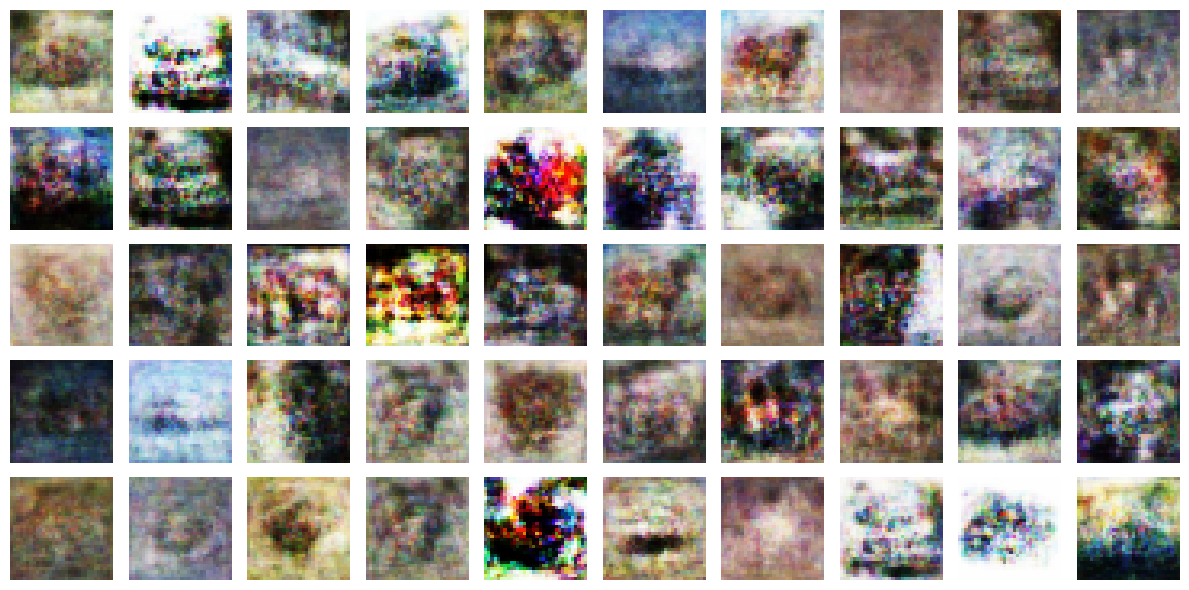

In [29]:
generator = Generator(100).to(device)
generator.load_state_dict(torch.load("./final_models/final_generator.pth", map_location=device))
display_test_samples(generator, device)